# FoodVision app using PyTorch model leveraging Food101 dataset

## Get setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Trying to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[INFO] Couldn't find torchinfo... installing it.


## Creating an EffNetB2 feature extractor

In [2]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

effnetb2_transforms = EfficientNet_B2_Weights.DEFAULT.transforms()

effnetb2 = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 75.4MB/s]


In [3]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [4]:
effnetb2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1408, out_features=101, bias=True)
)

### Creating a function to make an EffNetB2 feature extractor + transforms

In [5]:
def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    def get_state_dict(self, *args, **kwargs):
        kwargs.pop("check_hash")
        return load_state_dict_from_url(self.url, *args, **kwargs)
    WeightsEnum.get_state_dict = get_state_dict

    transforms = EfficientNet_B2_Weights.DEFAULT.transforms()

    model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.3, inplace=True),
        torch.nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

In [6]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [7]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a large dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique

We will add TrivialAugment only to transform train data

In [8]:
effnetb2_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

effnetb2_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

## Getting data

In [10]:
from torchvision import datasets

from pathlib import Path
data_dir = Path('data')

train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform=effnetb2_train_transforms, # apply data augmentation to training data
                              download=True)
test_data = datasets.Food101(root=data_dir,
                             split='test',
                             transform=effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [04:42<00:00, 17695132.24it/s]


Extracting data/food-101.tar.gz to data


In [11]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Creating a subset of the Food101 dataset for faster experimenting

We want our first few experiments to run as quick as possible

To do so, let's make a subset of 20% of the data from Food101 dataset (training and test)

In [12]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float=0.2,
                  seed: int=42):
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1

    print(f'[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}')

    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))

    return random_split_1, random_split_2

In [13]:
train_data_20_percent, _ = split_dataset(train_data)
test_data_20_percent, _ = split_dataset(test_data)

len(train_data_20_percent), len(test_data_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


(15150, 5050)

## Creating DataLoaders for EffNetB2

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch

In [14]:
import os

num_workers = 2 # this value is very experimental
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_data_20_percent,
                                                       batch_size, # how many samples per batch?
                                                       shuffle=True,
                                                       num_workers=num_workers)

test_dataloader = torch.utils.data.DataLoader(test_data_20_percent,
                                                      batch_size,
                                                      shuffle=False,
                                                      num_workers=num_workers)

len(train_dataloader), len(test_dataloader)

(474, 158)

## Training EffNetB2

Things for training:
* 5 epochs
* Optimizer: torch.optim.Adam(lr=1e-3)
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`, since we're working with multi-class data
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric



Label smoothing helps to prevent overfitting (it's a regularization technique)

In [15]:
from typing import Dict, List, Tuple

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]}
    For example if training for epochs=2:
                    {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [16]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_results = train(effnetb2,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         loss_fn,
                         5,
                         device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6397 | train_acc: 0.2818 | test_loss: 2.8052 | test_acc: 0.4865
Epoch: 2 | train_loss: 2.8642 | train_acc: 0.4367 | test_loss: 2.4605 | test_acc: 0.5455
Epoch: 3 | train_loss: 2.6490 | train_acc: 0.4860 | test_loss: 2.3630 | test_acc: 0.5547
Epoch: 4 | train_loss: 2.5493 | train_acc: 0.5063 | test_loss: 2.3109 | test_acc: 0.5715
Epoch: 5 | train_loss: 2.5000 | train_acc: 0.5236 | test_loss: 2.2746 | test_acc: 0.5852


### Creating a function to visualize loss curves

In [17]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

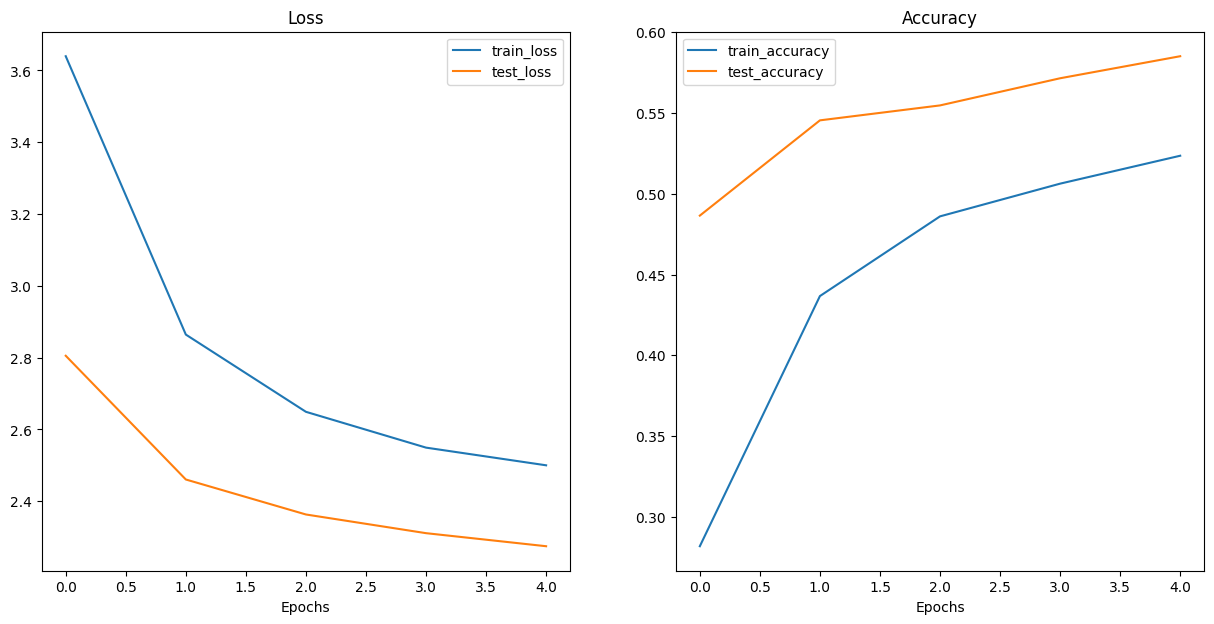

In [18]:
plot_loss_curves(effnetb2_results)

## Creating the function to save the model

In [19]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [20]:
effnetb2_model_path = 'effnetb2_feature_extractor_20_percent.pth'

save_model(effnetb2,
           'models/',
           effnetb2_model_path)

[INFO] Saving model to: models/effnetb2_feature_extractor_20_percent.pth


## Checking the size of the model

In [21]:
effnetb2_size = Path('models/effnetb2_feature_extractor_20_percent.pth').stat().st_size / 1024 / 1024
print(f'Pretrained EffNetB2 feature extractor model size: {effnetb2_size:.2f} MB')

Pretrained EffNetB2 feature extractor model size: 30.37 MB


## Turning the model into a deployable app

Deploying a model allows you to see how model goes in the real-world (the ultimate test set)

Let's create an outline for the app:

```
demos/
  foodvision/
    effnetb2_feature_extractor_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
      example_2.jpg
      example_3.jpg
    model.py
    requirements.txt
```

In [22]:
demo_path = Path('demos/foodvision/')

demo_path.mkdir(parents=True,
                exist_ok=True)

(demo_path / 'examples').mkdir(parents=True,
                               exist_ok=True)

### Creating a folder of example images and moving them to the `examples` directory

In [23]:
import shutil

examples_path = demo_path / 'examples'

examples = [Path('data/food-101/images/baklava/1006121.jpg'),
            Path('data/food-101/images/cheesecake/1021942.jpg'),
            Path('data/food-101/images/pancakes/1042445.jpg')]

for example in examples:
    destination = examples_path / example.name
    print(f'[INFO] Copying {example} to {destination}')
    shutil.copy2(src=example,
                 dst=destination)

[INFO] Copying data/food-101/images/baklava/1006121.jpg to demos/foodvision/examples/1006121.jpg
[INFO] Copying data/food-101/images/cheesecake/1021942.jpg to demos/foodvision/examples/1021942.jpg
[INFO] Copying data/food-101/images/pancakes/1042445.jpg to demos/foodvision/examples/1042445.jpg


In [25]:
import os

example_list = [['examples/' + example] for example in os.listdir(examples_path)]
example_list

[['examples/1042445.jpg'], ['examples/1006121.jpg'], ['examples/1021942.jpg']]

In [26]:
!mv models/effnetb2_feature_extractor_20_percent.pth demos/foodvision/

### Saving class names of the dataset to file (`class_names.txt`)

Let's save all of the class names to a .txt file so we can import them and use them in our app

In [27]:
class_names_path = demo_path / 'class_names.txt'
class_names_path

PosixPath('demos/foodvision/class_names.txt')

In [28]:
with open(class_names_path, 'w') as f:
    print(f'[INFO] Saving class names to {class_names_path}')
    f.write('\n'.join(class_names))

[INFO] Saving class names to demos/foodvision/class_names.txt


### Turning our model into a Python script (`model.py`)

In [30]:
%%writefile demos/foodvision//model.py
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    def get_state_dict(self, *args, **kwargs):
        #kwargs.pop("check_hash")
        return load_state_dict_from_url(self.url, *args, **kwargs)

    WeightsEnum.get_state_dict = get_state_dict

    transforms = EfficientNet_B2_Weights.DEFAULT.transforms()

    model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

Writing demos/foodvision//model.py


### Turning our FoodVision Big Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with a Python list
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [31]:
%%writefile demos/foodvision/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open('class_names.txt', 'r') as f:
    class_names = [food.strip() for food in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(101)

effnetb2.load_state_dict(
    torch.load(f='effnetb2_feature_extractor_20_percent.pth',
               map_location=torch.device('cpu')) # load the model to the CPU
)

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    return pred_labels_and_probs, pred_time

example_list = [['examples/' + example] for example in os.listdir('examples')]


title = 'FoodVision 🥙'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images of food into 101 different classes'
article = 'Created at 10 PyTorch Model Deployment'

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Writing demos/foodvision/app.py


### Creating a requirements file for FoodVision Big (`requirements.txt`)

In [32]:
%%writefile demos/foodvision/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==4.12.0

Writing demos/foodvision/requirements.txt


## Downloading app files

In [33]:
# # Download
# try:
#     from google.colab import files
#     files.download('demos/foodvision_big.zip')
# except:
#     print(f'Not running in Google Colab')